In [ ]:

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and normalize the data
X = np.load("X.npy")  # Shape: (N, 1000, 12)
y = np.load("y.npy")  # Shape: (N, 2000, 12)
#y = y[:, :1000, :]

# Normalize features across all samples and timesteps
X_mean = X.mean(axis=(0, 1), keepdims=True)
X_std = X.std(axis=(0, 1), keepdims=True)
X = (X - X_mean) / (X_std + 1e-8)

y_mean = y.mean(axis=(0, 1), keepdims=True)
y_std = y.std(axis=(0, 1), keepdims=True)
y = (y - y_mean) / (y_std + 1e-8)

# 2. Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 3. Dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# 4. Define LSTM model with Dropout
class LSTMPredictor(nn.Module):
    def __init__(self, input_size=12, hidden_size=384, num_layers=3, dropout=0.3, output_seq_len=2000):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_seq_len = output_seq_len

        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.decoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

       
        self.activation = nn.Tanh()

       
        self.decoder_mid = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh()
        )

        self.fc_out = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        batch_size = x.size(0)

        # Encode
        _, (hidden, cell) = self.encoder(x)

        # Start decoder with last input
        decoder_input = x[:, -1:, :]  # Shape: (batch, 1, input_size)
        outputs = []

        for _ in range(self.output_seq_len):
            out, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            #out = self.activation(out)
            out = self.decoder_mid(out)
            prediction = self.fc_out(out)  # Shape: (batch, 1, input_size)
            outputs.append(prediction)
            decoder_input = prediction  # Auto-regression

        return torch.cat(outputs, dim=1)  # (batch, 2000, input_size)



# 5. Instantiate model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMPredictor().to(device)
#weights = torch.tensor([770, 45, 1.05])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 6. Training loop
for epoch in range(1, 61):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                outputs = model(val_X)
                val_loss += criterion(outputs, val_y).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch}, Training Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

model.eval()
total_mse = total_mae = 0
r2_scores = []

with torch.no_grad():
    for val_X, val_y in val_loader:
        val_X, val_y = val_X.to(device), val_y.to(device)
        outputs = model(val_X)

        total_mse += nn.functional.mse_loss(outputs, val_y, reduction='sum').item()
        total_mae += nn.functional.l1_loss(outputs, val_y, reduction='sum').item()

        # Optionally compute R^2 score
        pred_np = outputs.cpu().numpy().reshape(-1, 12)
        true_np = val_y.cpu().numpy().reshape(-1, 12)
        r2_scores.append(r2_score(true_np, pred_np))

avg_mse = total_mse / len(val_dataset)
avg_mae = total_mae / len(val_dataset)
avg_r2 = np.mean(r2_scores)

print(f"\nValidation MSE: {avg_mse:.4f}")
print(f"Validation MAE: {avg_mae:.4f}")
print(f"Validation R² Score: {avg_r2:.4f}")

torch.save(model.state_dict(), "lstm_model.pth")





Epoch 1, Training Loss: 1.2400, Val Loss: 1.1209
Epoch 10, Training Loss: 0.7970, Val Loss: 1.0952


KeyboardInterrupt: 

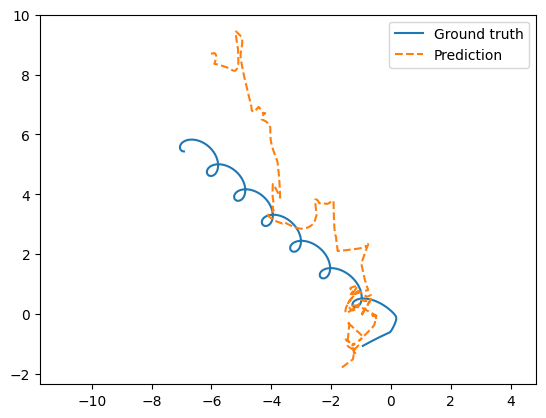

2000


2000

In [ ]:
X = np.load("X.npy")
y = np.load("y.npy")


X_norm = (X - X_mean) / (X_std + 1e-8)
y_norm = (y - y_mean) / (y_std + 1e-8)

i = 1 # sample index 70, 
z = np.concatenate((X[i], y[i]), axis=0)

input_seq = torch.tensor(X_norm[i], dtype=torch.float32).unsqueeze(0).to(device)  # (1, 1000, 12)

true_future = y[i] # (4000, 12)
model.eval()
with torch.no_grad():
    pred_norm = model(input_seq).squeeze(0).cpu().numpy()


pred = pred_norm * y_std.squeeze() + y_mean.squeeze()
true_future = true_future  

# Plot trajectory for body 0
plt.plot(true_future[:, 0], true_future[:, 1], label="Ground truth")
plt.plot(pred[:, 0], pred[:, 1], '--', label="Prediction")
plt.legend()
plt.axis("equal")
plt.show()
print(len(pred))
len(true_future)